# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [8]:
# Restart the Kernel after you execute this command.

!python3 -m pip install -r requirements.txt

**Important: Restart the Kernel at this moment**

## Imports

In [9]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [10]:
from torch.utils.data import DataLoader
# Define transforms as a list
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create MNIST training dataset and DataLoader
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)

# Create MNIST test dataset and DataLoader
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False, num_workers=2)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?


We used two steps to prepare the MNIST images before training:

1. **`transforms.ToTensor()`**

   * This changes the images into a format that PyTorch can work with (called a tensor).
   * It also changes the pixel values from numbers between 0 and 255 to numbers between 0 and 1, which makes it easier for the model to learn.

2. **`transforms.Normalize((0.1307,), (0.3081,))`**

   * This step helps make the image data more balanced.
   * It centers the data around 0 and makes the brightness of the images more consistent.
   * This helps the model train faster and more accurately.




## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [11]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


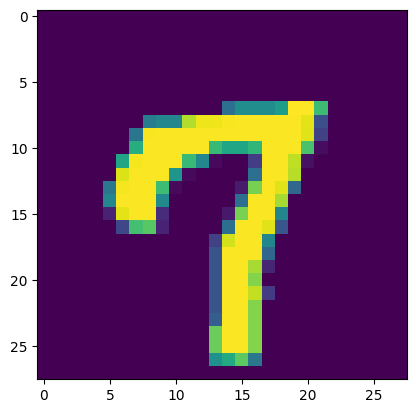

6


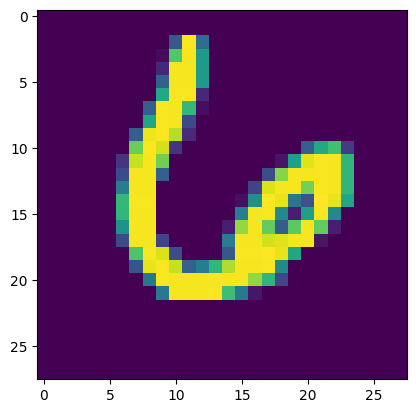

4


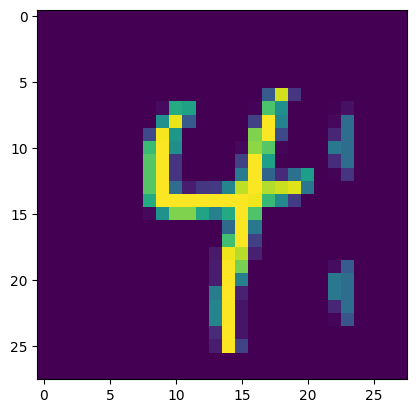

1


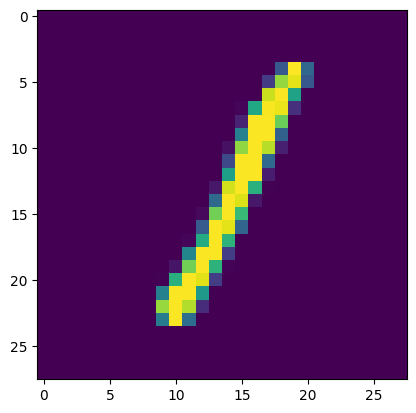

8


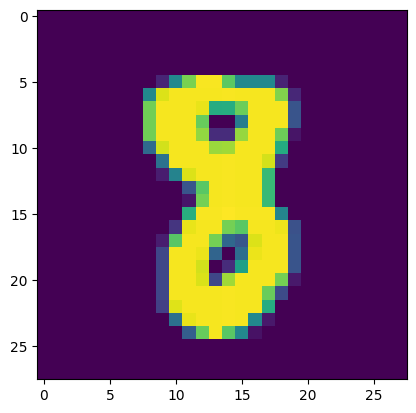

In [12]:
# Step 1: Import transforms (if not already done)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 2: Define transform for viewing (only ToTensor, no Normalize)
view_transform = transforms.ToTensor()

# Step 3: Create dataset and dataloader
view_dataset = datasets.MNIST(root='./data', train=True, transform=view_transform, download=True)
view_loader = DataLoader(view_dataset, batch_size=5, shuffle=True)

# Step 4: Call the show5 function
show5(view_loader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [13]:
import torch.nn as nn
import torch.nn.functional as F
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)     # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(64, 10)      # Hidden layer to output layer (10 digits)

    def forward(self, x):
        x = self.flatten(x)        # Flatten 28x28 image to 784
        x = F.relu(self.fc1(x))    # First hidden layer with ReLU
        x = F.relu(self.fc2(x))    # Second hidden layer with ReLU
        x = self.fc3(x)            # Output layer (raw scores / logits)
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [14]:
import torch
import torch.optim as optim

# Step 1: Instantiate the model
model = MNISTNet()

# Step 2: Choose a loss function
# CrossEntropyLoss is the standard for multi-class classification like MNIST (10 digits)
criterion = nn.CrossEntropyLoss()

# Step 3: Choose an optimizer
# Adam is a good default optimizer for neural networks
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [15]:
import torch

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to the device
model.to(device)

# Set number of epochs
epochs = 5

# Store average loss per epoch
epoch_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Optionally print every 250 batches
        if (batch_idx + 1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}], Loss: {loss.item():.4f}")

    # Average loss for this epoch
    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {average_loss:.4f}")


Using device: cpu
Epoch [1/5], Step [250], Loss: 0.1810
Epoch [1/5], Step [500], Loss: 0.1677
Epoch [1/5], Step [750], Loss: 0.1617
Epoch [1/5] Average Loss: 0.2716
Epoch [2/5], Step [250], Loss: 0.0671
Epoch [2/5], Step [500], Loss: 0.0636
Epoch [2/5], Step [750], Loss: 0.1424
Epoch [2/5] Average Loss: 0.1145
Epoch [3/5], Step [250], Loss: 0.1523
Epoch [3/5], Step [500], Loss: 0.0625
Epoch [3/5], Step [750], Loss: 0.0479
Epoch [3/5] Average Loss: 0.0807
Epoch [4/5], Step [250], Loss: 0.0120
Epoch [4/5], Step [500], Loss: 0.0855
Epoch [4/5], Step [750], Loss: 0.0756
Epoch [4/5] Average Loss: 0.0625
Epoch [5/5], Step [250], Loss: 0.0485
Epoch [5/5], Step [500], Loss: 0.0700
Epoch [5/5], Step [750], Loss: 0.0238
Epoch [5/5] Average Loss: 0.0494


Plot the training loss (and validation loss/accuracy, if recorded).

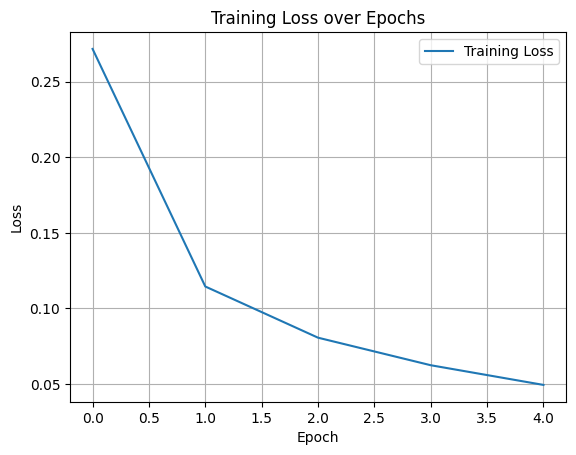

In [17]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
correct = 0
total = 0

model.eval()  # Set model to evaluation mode

with torch.no_grad():  # No need to compute gradients when testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get predicted class with highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 97.17%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
# Try increasing epochs
epochs = 10  # Instead of 5

# Try increasing hidden layer size
self.fc1 = nn.Linear(28*28, 256)
self.fc2 = nn.Linear(256, 128)

# Try different optimizer or learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower learning rate


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##